In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from condlib import conductance_matrix_READ
from timeit import default_timer as timer

In [3]:
# Memory array parameters
rL = 4.8
rHRS = 1e6
rPU = 1e3
n = 64
vRead = [0.5, 1.0, 1.6, 2.0, 2.5, 3.0, 4.0]

In [4]:
hubList = []
lsbList = []
WLvoltagesList = []
BLvoltagesList = []
cellVoltagesList = []

In [5]:
for v in vRead:
    # Voltages for BLs and WLs (read voltages, unselected floating)
    vBLsel = 0.0
    vWLsel = v

    start_t = timer()
    # Create conductance matrix
    conductancematrix, iinvector = conductance_matrix_READ(n, rL, rHRS, rPU,
                                                           vWLsel, vBLsel,
                                                           isel=n-1, jsel=n-1, verbose=False)
    # Convert to sparse matrix (CSR)
    conductancematrix = csr_matrix(conductancematrix)
    # Solve
    voltages = spsolve(conductancematrix, iinvector)
    stop_t = timer()

    # Separate WL and BL nodes and calculate cell voltages
    WLvoltages = voltages[:n*n].reshape((n, n))
    BLvoltages = voltages[n*n:].reshape((n, n))
    WLvoltagesList.append(WLvoltages)
    BLvoltagesList.append(BLvoltages)

    cellVoltages = abs(BLvoltages - WLvoltages)
    cellVoltagesList.append(cellVoltages)

    # Calculate Highest Unselected Bit and Lowest Selected Bit
    hub = cellVoltages[0][n-1]
    lsb = cellVoltages[n-1][n-1]
    hubList.append(hub)
    lsbList.append(lsb)
    
    print "{:.4f} sec".format(stop_t - start_t)
    print "Write voltage          : {:.4f} V".format(v)
    print "Highest unselected bit : {:.4f} V".format(hub)
    print "Lowest selected bit    : {:.4f} V".format(lsb)

1.0048 sec
Write voltage          : 0.5000 V
Highest unselected bit : 0.2330 V
Lowest selected bit    : 0.4653 V
0.9730 sec
Write voltage          : 1.0000 V
Highest unselected bit : 0.4661 V
Lowest selected bit    : 0.9305 V
0.9008 sec
Write voltage          : 1.6000 V
Highest unselected bit : 0.7458 V
Lowest selected bit    : 1.4889 V
0.9977 sec
Write voltage          : 2.0000 V
Highest unselected bit : 0.9322 V
Lowest selected bit    : 1.8611 V
1.0228 sec
Write voltage          : 2.5000 V
Highest unselected bit : 1.1652 V
Lowest selected bit    : 2.3264 V
0.9683 sec
Write voltage          : 3.0000 V
Highest unselected bit : 1.3983 V
Lowest selected bit    : 2.7916 V
0.9747 sec
Write voltage          : 4.0000 V
Highest unselected bit : 1.8644 V
Lowest selected bit    : 3.7222 V


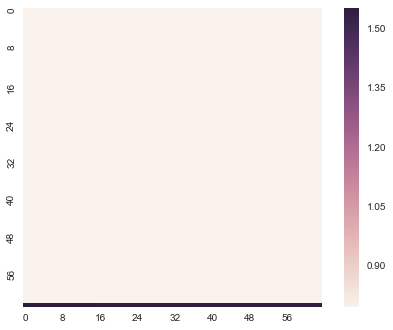

In [6]:
if n < 9:
    sns.heatmap(WLvoltagesList[2], square=True)
else:
    sns.heatmap(WLvoltagesList[2], square=True, xticklabels=n/8, yticklabels=n/8)
plt.savefig("figures/read_mapWL_{}.png".format(n))

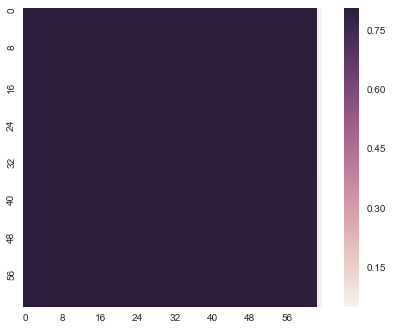

In [7]:
if n < 9:
    sns.heatmap(BLvoltagesList[2], square=True)
else:
    sns.heatmap(BLvoltagesList[2], square=True, xticklabels=n/8, yticklabels=n/8)
plt.savefig("figures/read_mapBL_{}.png".format(n))

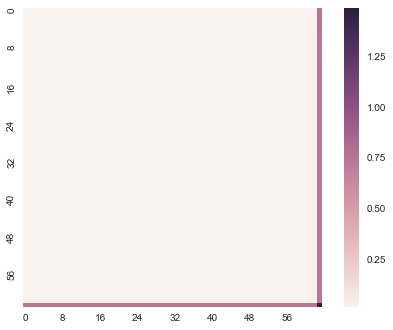

In [8]:
if n < 9:
    sns.heatmap(cellVoltagesList[2], square=True)
else:
    sns.heatmap(cellVoltagesList[2], square=True, xticklabels=n/8, yticklabels=n/8)
plt.savefig("figures/read_mapCell_{}.png".format(n))

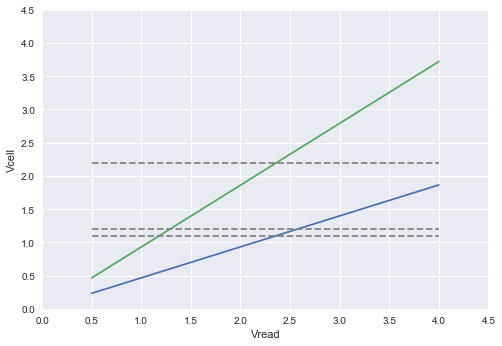

In [9]:
plt.plot(vRead, hubList, vRead, lsbList)
plt.plot([0.5, 4], [1.1, 1.1], [0.5, 4], [2.2, 2.2], c='gray', ls='--')
plt.plot([0.5, 4], [1.2, 1.2], c='gray', ls='--')
plt.xlim([0,4.5])
plt.ylim([0,4.5])
plt.ylabel("Vcell")
plt.xlabel("Vread")
plt.savefig("figures/read_margin_{}.png".format(n))
plt.show()